States: [tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]
Shape before Advantages: 4
Episode: 0, Reward: -5, Success: False
States: [tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]
Shape before Advantages: 1
Episode: 1, Reward: -5, Success: False
States: [tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tenso

/tmp/ipykernel_20998/1685069740.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantages_tensor = torch.tensor(advantages, dtype=torch.float32)


Episode: 33, Reward: -5, Success: False
States: [tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0.

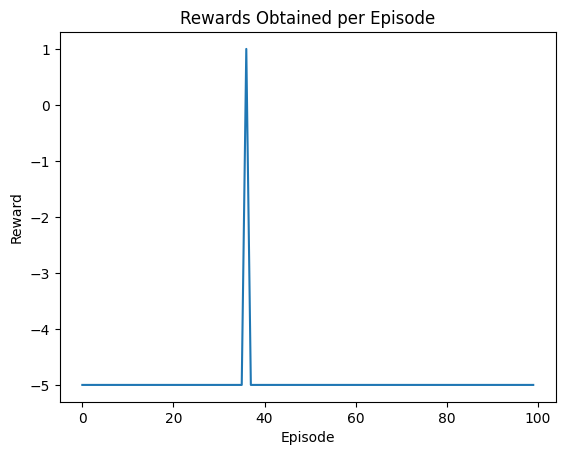

Success rate: 1.0%


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
from gym.envs.registration import register
import random
from collections import deque
import matplotlib.pyplot as plt

# Register the custom FrozenLake environment
register(
    id='CustomRewardFrozenLake-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78,  # Adjust the reward threshold if needed
)

# Define the custom FrozenLake environment with modified rewards
class CustomRewardFrozenLake(gym.Env):
    def __init__(self):
        self.env = gym.make("CustomRewardFrozenLake-v1")
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if reward == 0 and not done:
            reward = 0
        elif reward == 0 and done:
            reward = -5
        elif reward == 1:
            reward = 1
        return state, reward, done, info

    def reset(self):
        return self.env.reset()

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

# Define Actor Network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Define Critic Network
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define Experience Buffer
class ExperienceBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, log_prob, value, reward, done):
        self.buffer.append((state, action, log_prob, value, reward, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, log_probs, values, rewards, dones = zip(*batch)
        return states, actions, log_probs, values, rewards, dones

# PPO loss function
def calculate_ppo_loss(actor, critic, states, actions, log_probs_old, values_old, advantages, epsilon=0.2, c1=0.5, c2=0.01):
    policy = actor(states)
    dist = torch.distributions.Categorical(policy)

    log_probs = dist.log_prob(actions)
    ratios = torch.exp(log_probs - log_probs_old)
    surr1 = ratios * advantages
    surr2 = torch.clamp(ratios, 1.0 - epsilon, 1.0 + epsilon) * advantages

    actor_loss = -torch.min(surr1, surr2).mean()

    values = critic(states)
    critic_loss = (values - values_old).pow(2).mean()

    entropy = dist.entropy().mean()

    total_loss = actor_loss + c1 * critic_loss - c2 * entropy

    return actor_loss, critic_loss

# Discounted rewards function
def discount_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_add = 0
    for r in reversed(rewards):
        running_add = running_add * gamma + r
        discounted_rewards.insert(0, running_add)
    return discounted_rewards

# Function to compute advantages
def compute_advantages(critic, states, rewards):
    values = critic(states).squeeze()
    rewards_tensor = torch.tensor(rewards, dtype=torch.float32)  # Convert rewards to a PyTorch tensor
    advantages = rewards_tensor - values
    return advantages

class ProblemSolver:
    def __init__(self, env):
        self.env = env
        self.actor = Actor(env.observation_space.n, env.action_space.n)
        self.critic = Critic(env.observation_space.n)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)

    def choose_action(self, state):
        state_one_hot = torch.zeros(1, self.env.observation_space.n)
        state_one_hot[0, state] = 1
        policy = self.actor(state_one_hot)
        action_probs = torch.softmax(policy, dim=-1)
        action = np.random.choice(env.action_space.n, p=action_probs.detach().numpy().flatten())
        return action

    def update(self, states, actions, log_probs, values, rewards, dones):
        discounted_rewards = discount_rewards(rewards)

        print(f"Shape before Advantages: {states}")
        advantages = compute_advantages(self.critic, torch.stack(states), discounted_rewards)
        
        actions_tensor = torch.tensor(actions, dtype=torch.int64)
        log_probs_tensor = torch.cat(log_probs)
        values_tensor = torch.cat(values)
        advantages_tensor = torch.tensor(advantages, dtype=torch.float32)

        actor_loss, critic_loss = calculate_ppo_loss(self.actor, self.critic, torch.stack(states), actions_tensor, log_probs_tensor, values_tensor, advantages_tensor)

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()


if __name__ == "__main__":
    env = CustomRewardFrozenLake()
    solver = ProblemSolver(env)
    num_episodes = 100
    episode_rewards = []
    success_count = 0

    for episode in range(num_episodes):
        state = env.reset()
        # print(f"State: {state}")
        states = []
        actions = []
        log_probs = []
        values = []
        rewards = []
        dones = []

        while True:
            action = solver.choose_action(state)
            next_state, reward, done, _ = env.step(action)

            state_one_hot = torch.zeros(1, env.observation_space.n)
            state_one_hot[0, state] = 1
            states.append(state_one_hot)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)

            policy = solver.actor(state_one_hot)
            dist = torch.distributions.Categorical(policy)
            log_prob = dist.log_prob(torch.tensor(action))
            log_probs.append(log_prob)
            value = solver.critic(state_one_hot)
            values.append(value)

            if done:
                if reward == 1:
                    success_count += 1
                break

            state = next_state
        print(f"States: {states}")
        solver.update(states, actions, log_probs, values, rewards, dones)
        episode_rewards.append(sum(rewards))

        print(f"Episode: {episode}, Reward: {sum(rewards)}, Success: {reward == 1}")

    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards Obtained per Episode')
    plt.show()

    success_rate = success_count / num_episodes * 100
    print(f"Success rate: {success_rate}%")
    env.close()
